# 프로젝트: 뉴스기사 요약해보기

## 🥇루브릭 기준 
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
   - **분석단계**, **정제단계**, **정규화**와 **불용어 제거**, **데이터셋 분리**, **인코딩** 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
   - 모델학습이 안정적으로 수렴되었음을 **그래프**를 통해 확인하였으며, 실제 요약문과 유사한 **요약문장**을 얻을 수 있었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
   - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

# Step 1. 데이터 수집하기
## DATA: [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary) 뉴스 기사 데이터`news_summary_more.csv`
- `text`, `headlines`

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- [pd.set_option](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.set_option.html)

In [4]:
import pandas as pd
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 100000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 1000)

pandas version:  1.2.0


In [5]:
data['headlines'].sample(10)

1451          Anil Ambani's younger son Anshul Ambani joins Reliance Group
90311    How does Railways plan to earn extra Ã¢ÂÂ¹40,000 cr in 10 years?
93166          Mother and daughter die after getting locked in Czech sauna
24562          Tour de France race halted as police gas protesting farmers
58158          It'll change my image: Sunny on her Telugu period war drama
17340         Hurricane reaches US East Coast, space station records video
21658         HC orders CBI to probe police firing during Sterlite protest
10588    Model Adriana Lima breaks down at her last Victoria's Secret show
15333           832 confirmed dead due to earthquake, tsunami in Indonesia
6991     I was vocal, paid the price by having unfulfilled career: Gambhir
Name: headlines, dtype: object

- 영어가 아닌 문자
- 괄호 안 문자
- 쌍 따옴포 문자
- 소유격
- 홑 따옴표 문자
- -로 이어진 문자

In [6]:
data['text'].sample(10)

60499                                                                                                     A 25-year-old woman in Telangana's Warangal on Friday filed a police complaint alleging that her husband made her leave the house for not being good at making his favourite biryani. The woman further alleged that this was the second time she was thrown out of the house for the same reason in less than a year.
8436                               RBI Governor Urjit Patel on Tuesday appeared before a parliamentary panel and reportedly committed to submit in writing his views on controversial issues including Section 7 of RBI Act cited by the government. During the session, Patel didn't answer specific questions on demonetisation, bad loans and RBI's autonomy, reports added. He will reportedly submit answers in 10-15 days.
72318                           US President Donald Trump has slammed former FBI Director James Comey over claims that he began drafting a statement to acquit Hillary

# 추상적 요약

## Step 2. 데이터 전처리하기
1. 결측값
2. 중복값
3. 텍스트 정규화와 불용어 제거
4. 여러가지 전처리

In [7]:
#1. 결측값
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [8]:
#2. 중복값
print(len(data))
data.nunique()

98401


headlines    98280
text         98360
dtype: int64

In [9]:
data.drop_duplicates(subset = ['text'], inplace = True)
print(len(data))

98360


In [13]:
#3. 텍스트 정규화와 불용어 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- html 태그 제거는 불필요함

In [7]:
for text in (text for text in data['text']):
#     result = BeautifulSoup(text, "lxml").findAll('<')
    result = text.find('<')
    if result > 0 :
        print(text[result:result+3])

In [53]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    #0-1. 무의미한 빈칸 제거: strip
    #0-2. 2개 이상의 공백 1개 공백으로 변환/이거 안해도 되긴 되네, 왜 그렇지 ?
    
    #1. 텍스트 소문자화
    #3. 괄호로 닫힌 문자열 제거
    #6. 소유격 제거
    #5. 약어 정규화
    
    #4. 홑따옴표 제거, 쌍따옴표 제거
    
    #7. 영어 외 문자 공백으로 변환
    #8. m이 3개 이상이면 2개로 변경
    sentence = sentence.lstrip()
    sentence = sentence.lower() # 1
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 3
    
    sentence = re.sub(r"'s\b","", sentence) # 6
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    
    sentence = re.sub(r'[\'\"]','', sentence) # 4
    
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 7
    sentence = re.sub('[m]{2,}', 'mm', sentence) # 8
    
#     sentence = re.sub("[\s]{2,}", " ", sentence)#9
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [56]:
temp_text = 'Everything\'s "I bought was great",    !!!!infact ain\'t I ordered twice and the third ordered was for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered mother father
great way to start the day


In [58]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

179.67491602897644  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

## Step 2. 데이터 전처리하기 Part2
1. 결과의 결측값 확인 및 처리
2. 샘플의 최대 길이 정하기
   - 정해진 길이보다 길면 제외하기
4. 훈련, 검증 데이터 분리하기
5. 단어사전 만들기
6. 패딩하기

In [60]:
data['text'] = clean_text
data['headlines'] = clean_summary

In [61]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [62]:
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.121563643757625
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.294235461569745


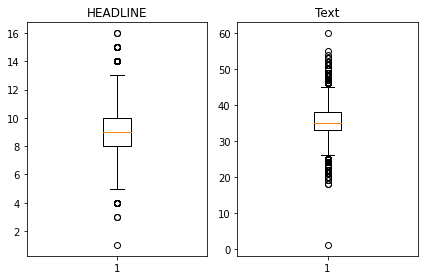

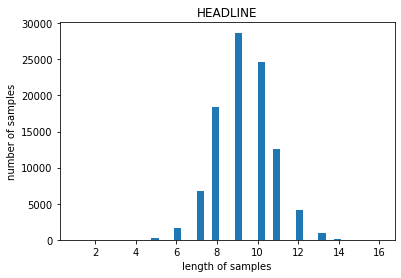

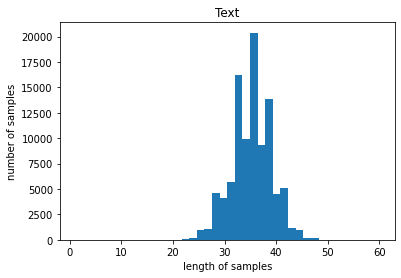

In [63]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('HEADLINE')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('HEADLINE')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 너무 예뻐서 버릴 이유가 없다! 최대값을 그대로 사용함

In [64]:
text_max_len = np.max(text_max_len)
headline_max_len = np.max(headline_len)

In [65]:
# def below_threshold_len(max_len, nested_list):
#     cnt = 0
#     for s in nested_list:
#         if(len(s.split()) <= max_len):
#             cnt = cnt + 1
#     print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# below_threshold_len(text_max_len, data['text'])
# below_threshold_len(headline_max_len,  data['headlines'])

# data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
# data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
# print('전체 샘플수 :', (len(data)))

In [68]:
# below_threshold_len(text_max_len, data['text'])
# below_threshold_len(headline_max_len,  data['headlines'])

In [ ]:
# data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
# data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
# print('전체 샘플수 :', (len(data)))

## 인코딩

In [69]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al with salary hike,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers,sostoken upgrad learner switches to career in ml al with salary hike,upgrad learner switches to career in ml al with salary hike eostoken
1,delhi techie wins free food from swiggy for one year on cred,kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit,sostoken delhi techie wins free food from swiggy for one year on cred,delhi techie wins free food from swiggy for one year on cred eostoken
2,new zealand end rohit sharma led india match winning streak,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history,sostoken new zealand end rohit sharma led india match winning streak,new zealand end rohit sharma led india match winning streak eostoken
3,aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken
4,have known hirani for yrs what if metoo claims are not true sonam,speaking sexual harassment allegations rajkumar hirani sonam kapoor said ive known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment added hirani accused assistant worked sanju,sostoken have known hirani for yrs what if metoo claims are not true sonam,have known hirani for yrs what if metoo claims are not true sonam eostoken


In [70]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[73535 64635 25920 ... 23892 65720 72620]
테스트 데이터의 수 : 19672
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 토크나이즈 

In [71]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [94]:
src_tokenizer.word_counts

OrderedDict([('star', 1311),
             ('sustains', 4),
             ('life', 2141),
             ('earth', 915),
             ('influence', 239),
             ('global', 1029),
             ('temperature', 179),
             ('increase', 714),
             ('since', 2779),
             ('germany', 557),
             ('based', 4725),
             ('study', 910),
             ('claimed', 4270),
             ('scientists', 887),
             ('marked', 147),
             ('last', 5266),
             ('years', 5982),
             ('temperatures', 151),
             ('increased', 587),
             ('rate', 568),
             ('seen', 1938),
             ('past', 871),
             ('co', 1670),
             ('levels', 289),
             ('industrialisation', 3),
             ('began', 555),
             ('mid', 281),
             ('th', 2467),
             ('century', 502),
             ('suggesting', 115),
             ('human', 1274),
             ('ousted', 137),
             ('cens

In [92]:
a = pd.Series(src_tokenizer.word_counts.values(), index = src_tokenizer.word_counts.keys())

In [97]:
a = a.sort_values()
a.value_counts()

1        24965
2         9883
3         5174
4         3282
5         2352
6         1861
7         1529
8         1210
9         1066
10         918
11         755
12         693
13         625
14         585
15         543
16         457
17         432
18         420
19         386
20         350
21         335
23         311
22         310
24         292
26         251
25         245
27         236
28         223
30         199
32         193
31         181
29         172
34         159
35         144
40         141
41         140
33         135
39         135
38         134
37         131
36         119
45         117
43         117
42         113
46         106
44         103
49         103
48         101
51         101
53          99
47          94
50          93
52          86
58          86
56          78
55          78
54          75
65          73
57          73
61          71
59          70
60          70
62          68
63          66
66          66
74          58
73        

In [98]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69705
등장 빈도가 6번 이하인 희귀 단어의 수: 47517
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22188
단어 집합에서 희귀 단어의 비율: 68.16871099634173
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4845183573372545


In [99]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [100]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[303, 135, 502, 2145, 437, 2770, 674, 99, 919, 34, 507, 40, 531, 3245, 29, 22, 3178, 858, 888, 157, 547, 22, 217, 1820, 858, 99, 924, 1868, 118, 1035, 3905, 324, 2145], [3437, 2484, 172, 321, 4390, 4086, 335, 3167, 5937, 494, 1, 659, 1473, 377, 343, 4391, 749, 10476, 228, 7087, 5229, 15393, 4, 103, 176, 15, 8315, 2159, 4086, 3356, 3167, 5937, 494], [959, 1076, 1124, 292, 434, 257, 197, 51, 210, 4117, 609, 5, 13, 1941, 609, 2438, 51, 115, 354, 247, 2620, 1173, 257, 5938, 681, 5, 1545, 1633, 1687, 3149, 2, 5, 107, 5617]]


In [101]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [102]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30139
등장 빈도가 5번 이하인 희귀 단어의 수: 19706
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10433
단어 집합에서 희귀 단어의 비율: 65.38372208766052
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.642204553311275


In [103]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1713, 80, 44, 4414, 7, 4027, 621, 9512, 1117, 125], [1, 1355, 80, 2159, 387, 6, 246, 3490, 86, 2442], [1, 566, 1453, 196, 150, 541, 5, 14, 31, 1392], [1, 80, 807, 71, 3907, 7, 2576, 7], [1, 2577, 3784, 5650, 3, 1118, 1282, 7, 34]]
target
decoder  [[1713, 80, 44, 4414, 7, 4027, 621, 9512, 1117, 125, 2], [1355, 80, 2159, 387, 6, 246, 3490, 86, 2442, 2], [566, 1453, 196, 150, 541, 5, 14, 31, 1392, 2], [80, 807, 71, 3907, 7, 2576, 7, 2], [2577, 3784, 5650, 3, 1118, 1282, 7, 34, 2]]


- 길이가 1인 문자열이 있다면 제거한다. 없으므로 넘어간다.

In [104]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
# decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
# decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

# encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
# decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
# decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

# print('훈련 데이터의 개수 :', len(encoder_input_train))
# print('훈련 레이블의 개수 :', len(decoder_input_train))
# print('테스트 데이터의 개수 :', len(encoder_input_test))
# print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩

In [106]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

## Step 3. RNN모델에 어텐션 메커니즘 적용하기

## 모델 설계 및 생성 

In [107]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [108]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [109]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [110]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [111]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 모델 학습하기

In [112]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 298s 931ms/step - loss: 4.6891 - val_loss: 3.9295
Epoch 2/50
308/308 [==============================] - 291s 945ms/step - loss: 3.8676 - val_loss: 3.6426
Epoch 3/50
308/308 [==============================] - 290s 942ms/step - loss: 3.5827 - val_loss: 3.4328
Epoch 4/50
308/308 [==============================] - 290s 943ms/step - loss: 3.3661 - val_loss: 3.2866
Epoch 5/50
308/308 [==============================] - 288s 936ms/step - loss: 3.1931 - val_loss: 3.1713
Epoch 6/50
308/308 [==============================] - 284s 922ms/step - loss: 3.0549 - val_loss: 3.0806
Epoch 7/50
308/308 [==============================] - 284s 923ms/step - loss: 2.9358 - val_loss: 3.0163
Epoch 8/50
308/308 [==============================] - 284s 922ms/step - loss: 2.8446 - val_loss: 2.9542
Epoch 9/50
308/308 [==============================] - 284s 922ms/step - loss: 2.7566 - val_loss: 2.9010
Epoch 10/50
308/308 [==============================] - 284s 923m

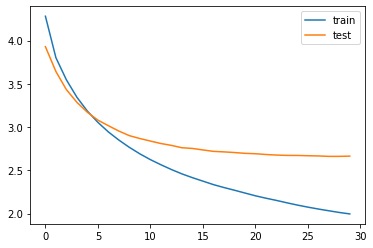

In [114]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기

In [115]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [116]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [117]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [126]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 추상적 요약: 인퍼런스 모델

In [128]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [129]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : maharashtra state excise department monday imposed fine lakh deepak bandra hill following complaints liquor home delivered night without proper license excise officer said liquor worth lakh sold without records unregistered employees used delivering liquor 
실제 요약 : mumbai bar fined lakh over home delivery of alcohol 
예측 요약 :  lakh fine for drug offenders in maharashtra


원문 : united states wednesday unveiled enhanced security measures us bound flights effort prevent expanding cabin ban laptops security measures require enhanced explosive detection screening personal electronic devices passengers affect lakh passengers commercial flights arriving daily airports countries 
실제 요약 : us unveils flight security plan to avoid laptop ban 
예측 요약 :  us approves laptop ban on flights from us airport


원문 : finance minister arun jaitley wednesday announced bjp celebrate anti black money day november mark one year since demonetisation announcement state bjp chiefs organise events highlight ach

### 소결론: Abstract
  - 의미없는 문장을 예측으로 도출하는 경우가 잦았고, 문장의 문법적 완성도가 떨어진다.
  - 그러나 요약의 핵심인 keyword 추출에는 높은 확률로 성공한 것으로 보인다.
  - 예를 들어 `prince harry meghan`, `wedding` 등의 keyword가 겹치는 것을 볼 수 있다.
    - 실제 요약 : prince harry meghan invite to their wedding 
    - 예측 요약 :  prince harry meghan markle markle to visit uk royal wedding
  - 대명사의 경우 소문자로 변환했음에도 문맥상 잘 찾아내는 걸 볼 수 있다.

# 추출적 요약

In [8]:
import requests
import summa
from summa.summarizer import summarize

In [9]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [10]:
data2.head()

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history."
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""In the #MeToo movement, I always believe a woman. But in this case, we need to reserve our judgment,"" she added. Hirani has been accused by an assistant who worked in 'Sanju'."


In [11]:
# 데이터 전처리 함수
def preprocess_sentence2(sentence, remove_stopwords=True):
    #0-1. 무의미한 빈칸 제거: strip
    #0-2. 2개 이상의 공백 1개 공백으로 변환/이거 안해도 되긴 되네, 왜 그렇지 ?
    
    #1. 텍스트 소문자화
    #3. 괄호로 닫힌 문자열 제거
    #6. 소유격 제거
    #5. 약어 정규화
    
    #4. 홑, 쌍따옴표 제거
    
    #7. 영어 외 문자 공백으로 변환
    #8. m이 3개 이상이면 2개로 변경
    sentence = sentence.lstrip()
    sentence = sentence.lower() # 1
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 3
    
    sentence = re.sub(r"'s\b","", sentence) # 6
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    
    sentence = re.sub(r'[\'\"]','', sentence) # 4
    
    sentence = re.sub("[^a-zA-Z\.]", " ", sentence) # 7
    sentence = re.sub('[m]{2,}', 'mm', sentence) # 8
    
#     sentence = re.sub("[\s]{2,}", " ", sentence)#9
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
texts = [preprocess_sentence2(text) for text in (text for text in data2['text'])]
data2['text'] = pd.DataFrame(texts)
data2['text'][:5]

0    saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience. program upgrad degree career support helped transition data scientist tech mahindra salary hike. upgrad online power learning powered lakh careers.
1                kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year. pranav kaushik delhi techie bagged reward spending cred coins. users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult.fit more.
2                         new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series. india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history.
3                                                          aegon life iterm insurance plan customers enjoy tax bene

In [15]:
print()
headlines2 = []
# count = 0

for text in (text for text in data2['text']):
    summary = summarize(text, ratio=0.4)
    headlines2.append(summary)
#     count += 1
#     if count == 1 :
#         break
        
data2['headlines2'] = pd.DataFrame(headlines2, columns = ['headlines2'] )

In [25]:
data2[ ['headlines', 'headlines2'] ][:10]

,headlines,headlines2
0,upGrad learner switches to career in ML & Al with 90% salary hike,upgrad online power learning powered lakh careers.
1,Delhi techie wins free food from Swiggy for one year on CRED,users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult.fit more.
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,
3,Aegon life iTerm insurance plan helps customers save tax,also customers options insure critical illnesses disability accidental death benefit rider life cover age years.
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam",speaking sexual harassment allegations rajkumar hirani sonam kapoor said ive known hirani many years...what true metoo movement get derailed.
5,Rahat Fateh Ali Khan denies getting notice for smuggling currency,pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india.
6,"India get all out for 92, their lowest ODI total in New Zealand",
7,Govt directs Alok Verma to join work 1 day before his retirement,
8,Called PM Modi 'sir' 10 times to satisfy his ego: Andhra CM,andhra pradesh cm chandrababu naidu said met us president bill clinton addressed mr clinton sir.
9,"Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats",congress candidate shafia zubair ramgarh assembly seat rajasthan defeating bjp sukhwant singh margin votes bypoll.


In [24]:
data2[ ['headlines', 'headlines2'] ][90:100]

,headlines,headlines2
90,"Shamita Shetty abused, driver slapped after accident: Report",actress shamita shetty verbally abused driver slapped incident road rage mumbai tuesday per reports.
91,Trolling has become the norm on social media: Vaani,actress vaani kapoor said trolling become norm social media adding one got trolled social media.
92,Whoever invented marriage was creepy as hell: Sushmita posts joke,insult beauty marriage instagram user commented post.
93,Actor Karanvir Bohra detained in Russia over passport damage,television actor karanvir bohra flew russia tuesday attend film festival detained moscow due passport damage.
94,"If I don't get an award, that award is at loss: SRK",speaking winning awards films shah rukh khan said get award award loss.
95,Actress Patralekhaa to make her Kannada film debut,
96,"Gmail faces temporary global outage, users face '404 error'",gmail tuesday faced global outage also affected india wherein certain users complained faced error message trying sign accounts.
97,Decide about an alliance within 15 days: Uddhav to BJP,shiv sena chief uddhav thackeray asked bjp decide alliance sena within days said bjp make concrete proposal alliance.
98,"Grand alliance, if wins, will see a new PM every day: Shah",said opposition thinking leading country leader.
99,Demonetisation made homes affordable for youth: PM Modi,added decisions like demonetisation rera put check black money used parked real estate sector.


## 소결론: Abstractive와 Extractive
- random_state값을 같이 줘서 test_split을 했더라면 두 값을 바로 비교할 수 있었을텐데, 훈련할 시간이 없어 시도하지 못하였다.
- 전체적인 경향은 기존 Script 예제에서 완성도 있는 문장을 추출했던 것과 다르게 news 요약 문제에 있어 Extractive 방식은 아예 요약을 하지 못하는 경우도 종종 보이는 등 좋은 결과를 보이지 못했다. 예를 들어 1번, 8번을 보면 문장이 이루어지지 않았다.
- 그러나 키워드를 추출하는 능력은 좋은 성능을 보였다. 예를 들어 92번, 100번 등의 요약을 보면 키워드와 문장구성력까지 훌륭하다.


## 회고
- 관련한 지식이 적어 어려움이 많은 노드였다.
- tensorflow에 대한 기초적인 지식(tensor, Constant, Variable)이 부족했고
- RNN과 Encoder, Decoder, Attention, Seq2Seq에 대한 지식이 부족했다.
- 관련한 지식들을 차근히 채워나가되 너무 붙잡고 늘어져서 시간을 빼앗기는 일을 지양해야 겠다고 생각했다.
- 영상처리 분야에 비해 자연어 처리는 정확한 표현을 했다 안했다를 수치적으로 표현하기 어려워 판단에 어려움이 있다.
- 많은 공부를 한 후에야 더 큰 이해를 할 수 있을 것으로 보인다.